## Libraries


In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import tensorflow as tf

In [ ]:
import keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from keras.models import load_model, Sequential
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet152
from tensorflow.keras.applications import ResNet152V2, InceptionV3, Xception

## Data Preprocessing


Before loading the Data, let's have a look at the **Data Distribution**.

In [ ]:
currentDirectory = os.getcwd()
currentDirectory

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
rootPath = '/content/gdrive/My Drive/Dataset/GarbageClassification/'
classNames = sorted(os.listdir(rootPath))
nClasses = len(classNames)
print(f"Number of Classes : {nClasses}")

Number of Classes : 6


In [ ]:
classDistribution = [len(os.listdir(rootPath + name)) for name in classNames]
classDistribution

[403, 501, 410, 594, 482, 137]

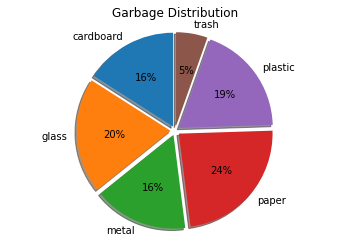

In [ ]:
# plt.pie(labels=classNames, x=classDistribution, autopct='%.0f%%')
labels = classNames
sizes = classDistribution
fig1, ax1 = plt.subplots()
explode = (0.05,0.05,0.05,0.05,0.05,0.05)
ax1.pie(sizes, labels=labels, explode=explode, autopct='%.0f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Garbage Distribution")
plt.show()

All the classes are **equally distributed**, this is a **good news** as it make sure that our **model cannot be biased**.

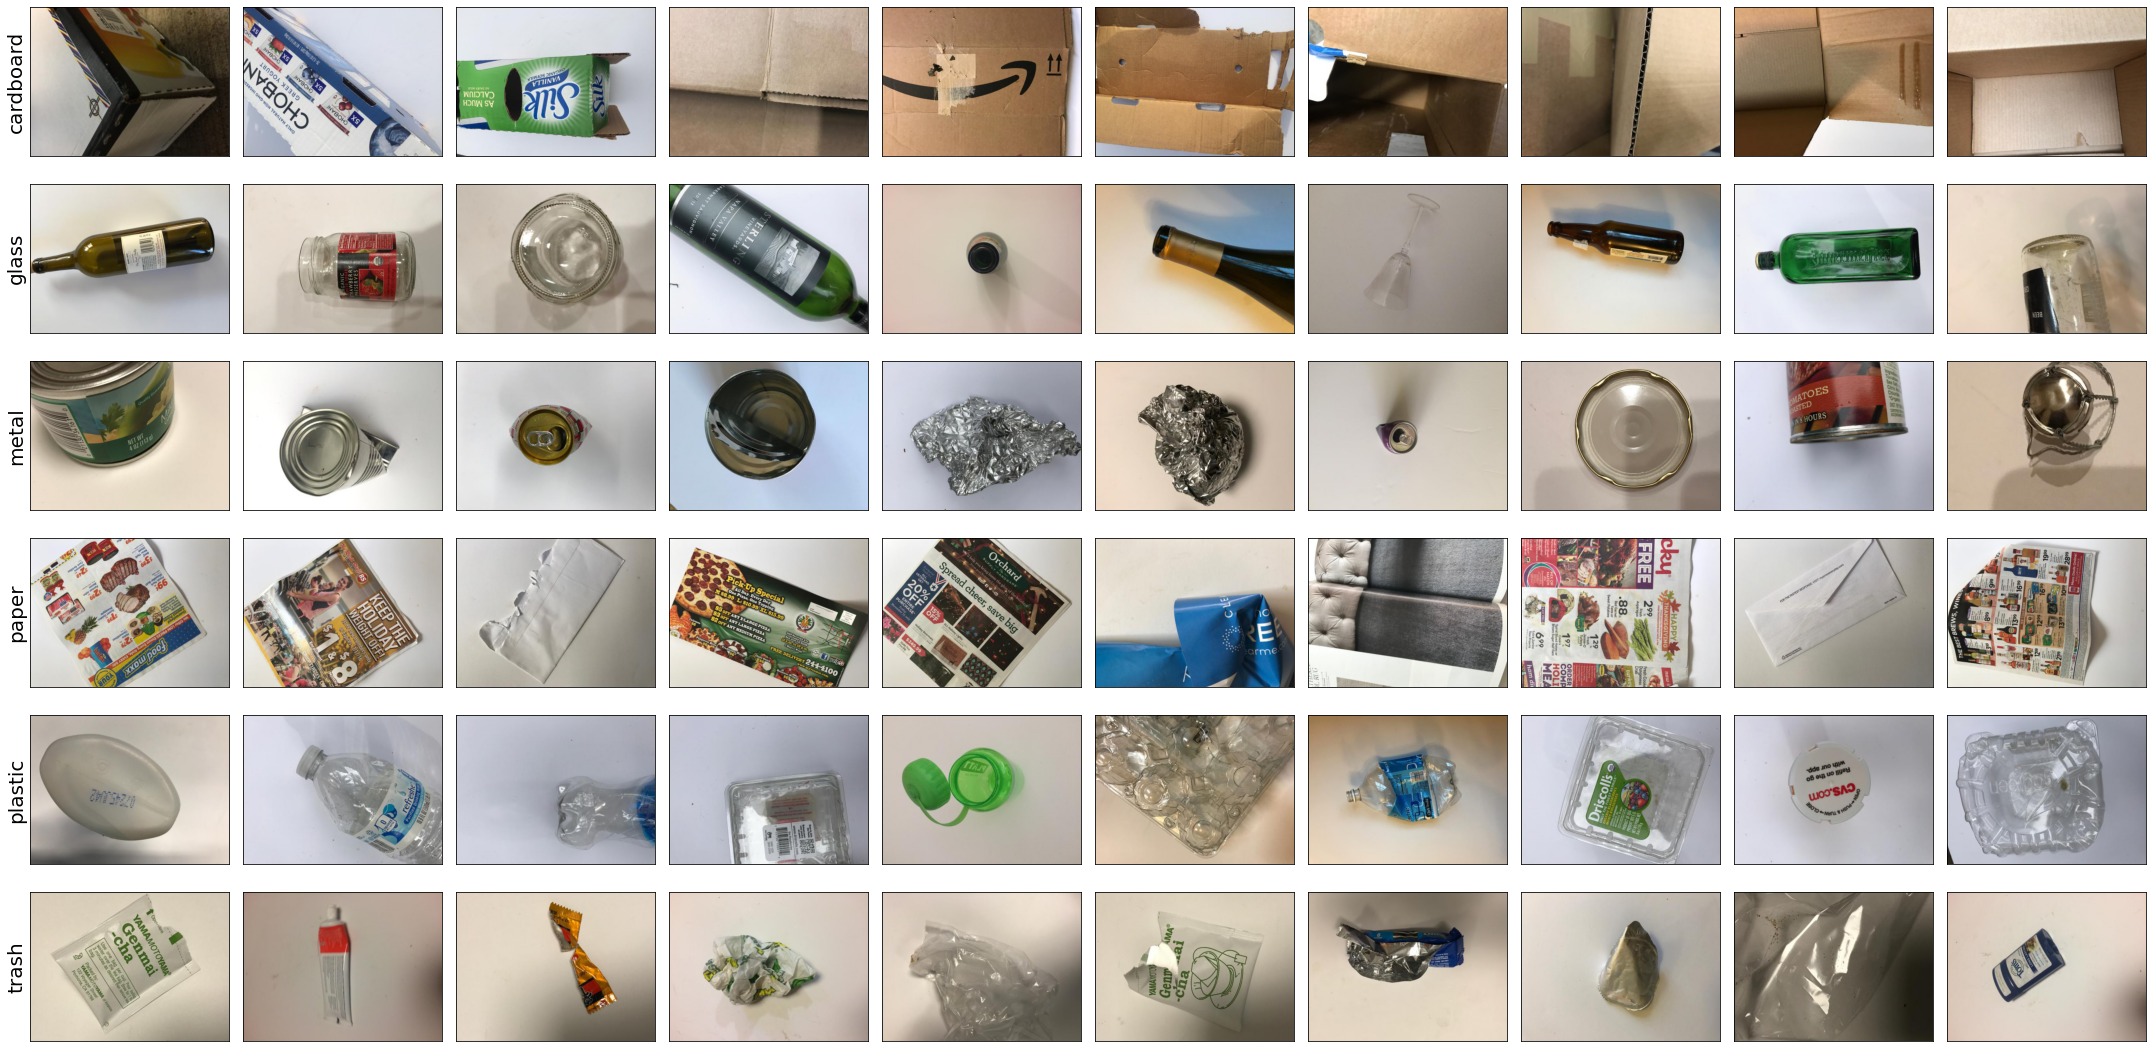

In [ ]:
import matplotlib.image as mpimg
train = os.path.join(rootPath)
plt.figure(figsize=(30,15))
for i in range(6):
    directory = os.path.join(train, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

## Data Loading

In [ ]:
# Initializing Generator
gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.25,
    interpolation_order=1
)

# Loading Data
train_ds = gen.flow_from_directory(rootPath, target_size=(256,256),
        shuffle=True, batch_size=32, subset='training', class_mode='binary')
valid_ds = gen.flow_from_directory(rootPath, target_size=(256,256),
        shuffle=True, batch_size=32, subset='validation', class_mode='binary')

Found 1898 images belonging to 6 classes.
Found 629 images belonging to 6 classes.


## Data Visualization

In [ ]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

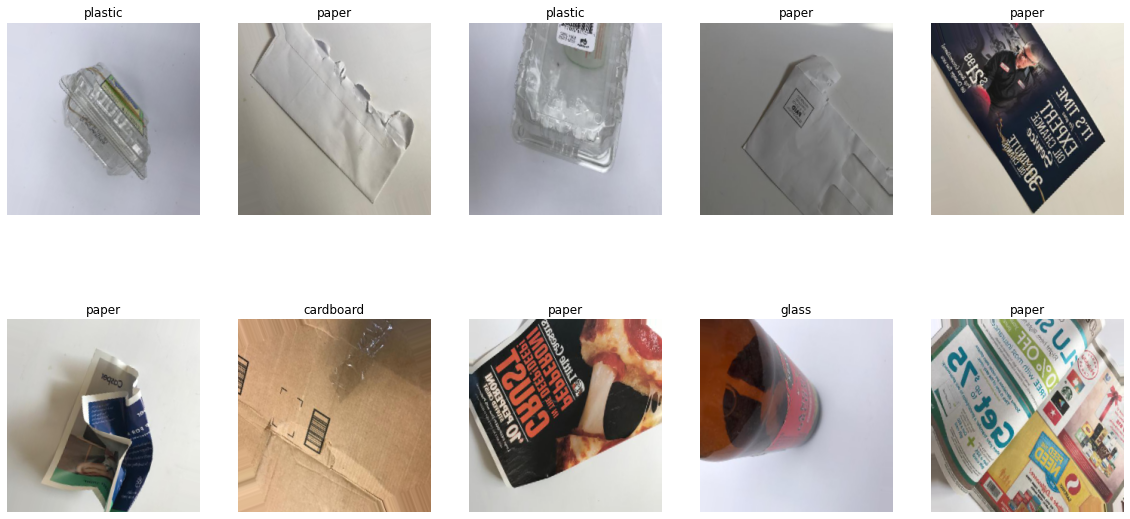

In [ ]:
temp = 1
plt.figure(figsize=(20,10))
for images, labels in train_ds:
    i = np.random.randint(len(images))
    image, label = images[i], labels[i]
    plt.subplot(2,5,temp)
    show_image(image, title=classNames[int(label)])
    temp+=1
    if temp>=11:
      break
plt.show()

## ResNet50V2

In [ ]:
# Loading Pretrained Model - ResNet50V2
baseModel = ResNet50V2(include_top=False,
                       weights='imagenet',
                       input_shape=(256,256,3))
baseModel.trainable = False

# Model Name
name = 'VIDA-ResNet50V2'

# Model Architecture
model = Sequential([
    baseModel,
    GAP(),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
], name=name)

# Compiling
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Callbacks
cbs = [EarlyStopping(patience=3, restore_best_weights=True),
       ModelCheckpoint(name + ".h5", save_best_only=True)]

# Training
history = model.fit(train_ds, validation_data=valid_ds,
                    epochs=50, callbacks=cbs)

94668760/94668760 [==============================] - 5s 0us/step
Epoch 1/50
60/60 [==============================] - 58s 771ms/step - loss: 0.6939 - accuracy: 0.7629 - val_loss: 0.6417 - val_accuracy: 0.7679
Epoch 2/50
60/60 [==============================] - 45s 743ms/step - loss: 0.2931 - accuracy: 0.8978 - val_loss: 0.6725 - val_accuracy: 0.7568
Epoch 3/50
60/60 [==============================] - 46s 762ms/step - loss: 0.2199 - accuracy: 0.9294 - val_loss: 0.7025 - val_accuracy: 0.7552
Epoch 4/50
60/60 [==============================] - 45s 753ms/step - loss: 0.1362 - accuracy: 0.9568 - val_loss: 0.6170 - val_accuracy: 0.7949
Epoch 5/50
60/60 [==============================] - 45s 747ms/step - loss: 0.0906 - accuracy: 0.9742 - val_loss: 0.6815 - val_accuracy: 0.7901
Epoch 6/50
60/60 [==============================] - 44s 739ms/step - loss: 0.0712 - accuracy: 0.9773 - val_loss: 0.7465 - val_accuracy: 0.7822
Epoch 7/50
60/60 [==============================] - 46s 767ms/step - loss: 0.

# **Learning Curve**

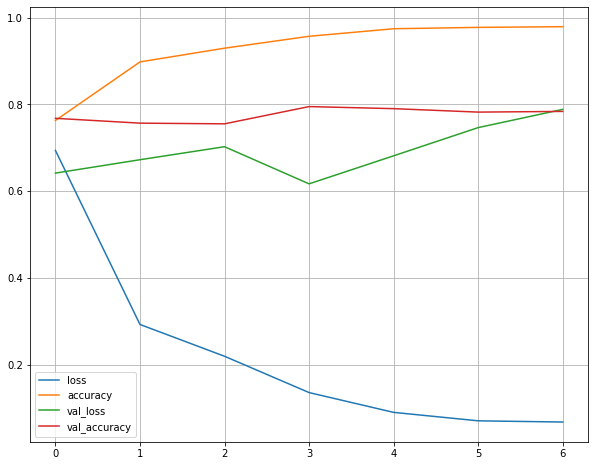

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.grid()
plt.show()

The **Learning Curve** is perfect.

# **Evaluation**

1/1 [==============================] - 0s 23ms/step


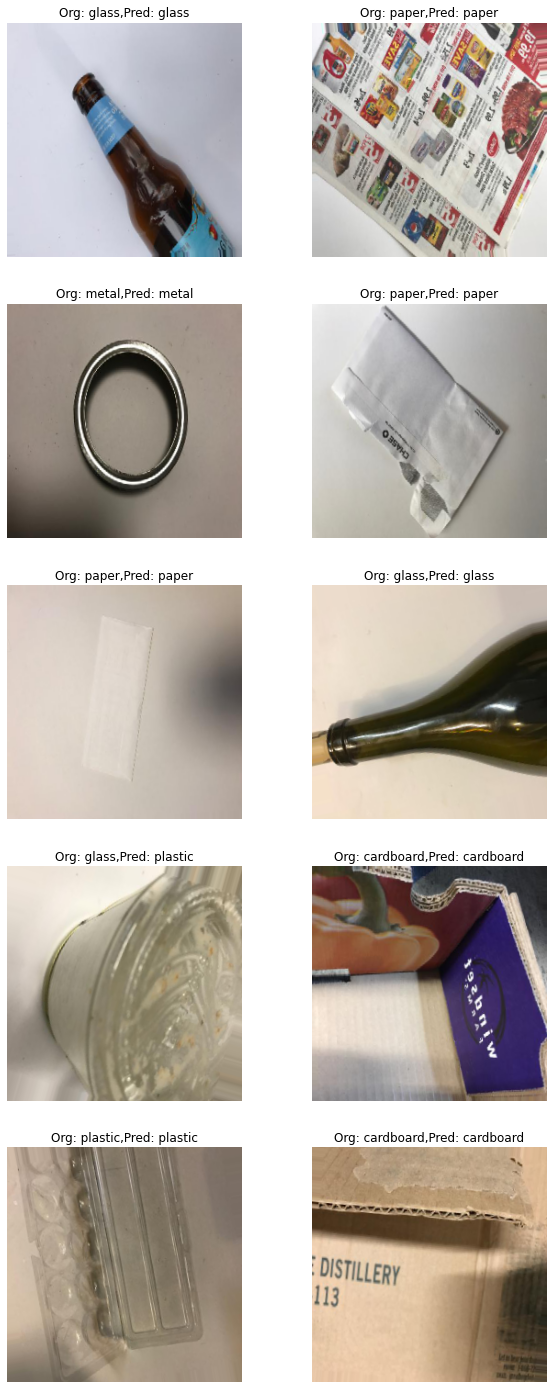

In [ ]:
i = 1
plt.figure(figsize=(10,25))
for images, labels in valid_ds:
    # Getting random image and label
    id = np.random.randint(len(images))
    image, label = images[id], labels[id]
    predLabel = classNames[np.argmax(model.predict(image[np.newaxis,...]))]
    plt.subplot(5,2,i)
    show_image(image, title="Org: {},Pred: {}".format(classNames[int(label)], predLabel))
    i+=1
    if i>=11:
      break
plt.show()

Model: "VIDA-ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 24,090,886
Trainable params: 526,086
Non-trainable params: 23,564,800
_________________________________________________________________
None


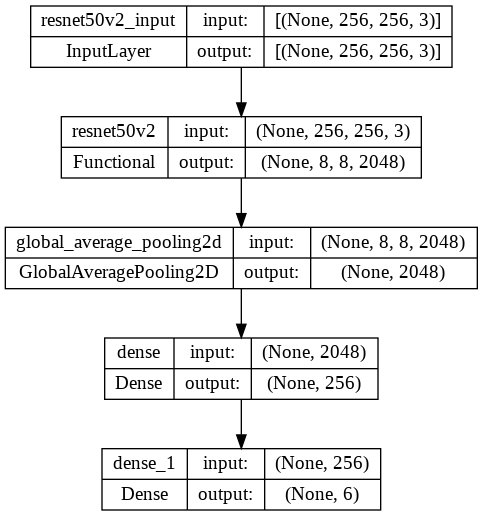

In [ ]:
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)